# Comprehensive PPG Analysis

In this tutorial we will learn how to extract biomarkers from a photoplethysmogram (PPG) signal.

Our objectives are to:

- Detect the standard fiducial points on PPG pulse waves
- Calculate pulse wave biomarkers from the fiducial points
- Saving data in different data format

You can use the sample PPG data by downloading it from the following link: [Sample PPG data](https://zenodo.org/record/8369487/files/Sample_PPG_MAT_125Hz.mat?download=1).


## Setup

Import Python packages:
________________________

- Install the _[pyPPG](https://pyppg.readthedocs.io/)_ toolbox for PPG analysis

In [ ]:
# !pip install pyPPG==1.0.41

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 68.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━

- Import required components from _pyPPG_

In [1]:
from pyPPG import PPG, Fiducials, Biomarkers
from pyPPG.datahandling import load_data, plot_fiducials, save_data
import pyPPG.preproc as PP
import pyPPG.fiducials as FP
import pyPPG.biomarkers as BM
import pyPPG.ppg_sqi as SQI

- Import other packages

In [2]:
import numpy as np
import sys
import json
import pandas as pd

Setup input parameters:
_______________________
_The following input parameters are inputs to the `pyPPG.example` module (see the [documentation](https://pyppg.readthedocs.io/en/latest/pyPPG.html#module-pyPPG.example) for further details)._

In [3]:
data_path = "dataset/data/S001_128.mat" # the path of the file containing the PPG signal to be analysed
start_sig = 0 # the first sample of the signal to be analysed
end_sig = -1 # the last sample of the signal to be analysed (here a value of '-1' indicates the last sample)
savingfolder = 'temp_dir'
savingformat = 'csv'

Load a raw PPG signal:
__________________________

In [4]:
signal = load_data(data_path=data_path, start_sig=start_sig, end_sig=end_sig, use_tk=False)
signal.v = signal.v [0:20*signal.fs] # 20 second long signal to be analysed

IndexError: invalid index to scalar variable.

Plot the raw PPG signal:

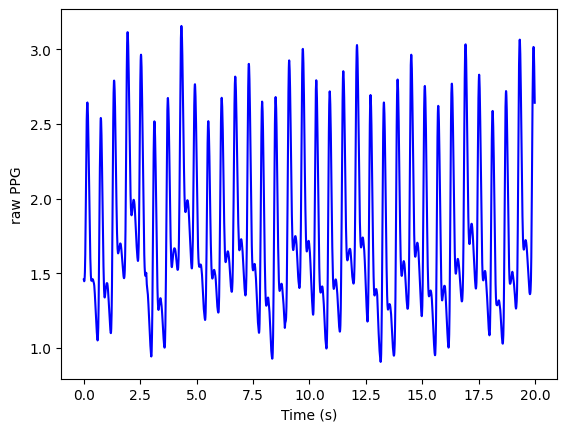

In [ ]:
# import plotting package
from matplotlib import pyplot as plt

# setup figure
fig, ax = plt.subplots()

# create time vector
t = np.arange(0, len(signal.v))/signal.fs

# plot raw PPG signal
ax.plot(t, signal.v, color = 'blue')
ax.set(xlabel = 'Time (s)', ylabel = 'raw PPG')

# show plot
plt.show()

## PPG signal processing

Filter the PPG signal and obtain first, second and third derivatives (_vpg_, _apg_, and _jpg_ respectively).

In [ ]:
signal.filtering = True # whether or not to filter the PPG signal
signal.fL=0.5000001 # Lower cutoff frequency (Hz)
signal.fH=12 # Upper cutoff frequency (Hz)
signal.order=4 # Filter order
signal.sm_wins={'ppg':50,'vpg':10,'apg':10,'jpg':10} # smoothing windows in millisecond for the PPG, PPG', PPG", and PPG'"

prep = PP.Preprocess(fL=signal.fL, fH=signal.fH, order=signal.order, sm_wins=signal.sm_wins)
signal.ppg, signal.vpg, signal.apg, signal.jpg = prep.get_signals(s=signal)

Plot the derived signals

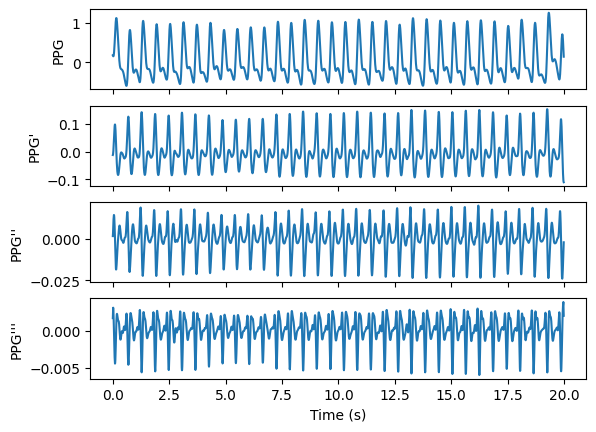

In [ ]:
# setup figure
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, sharex = True, sharey = False)

# create time vector
t = np.arange(0, len(signal.ppg))/signal.fs

# plot filtered PPG signal
ax1.plot(t, signal.ppg)
ax1.set(xlabel = '', ylabel = 'PPG')

# plot first derivative
ax2.plot(t, signal.vpg)
ax2.set(xlabel = '', ylabel = 'PPG\'')

# plot second derivative
ax3.plot(t, signal.apg)
ax3.set(xlabel = '', ylabel = 'PPG\'\'')

# plot third derivative
ax4.plot(t, signal.jpg)
ax4.set(xlabel = 'Time (s)', ylabel = 'PPG\'\'\'')

# show plot
plt.show()

Store the derived signals in a class

In [ ]:
# Initialise the correction for fiducial points
corr_on = ['on', 'dn', 'dp', 'v', 'w', 'f']
correction=pd.DataFrame()
correction.loc[0, corr_on] = True
signal.correction=correction

# Create a PPG class
s = PPG(signal)

Identify fiducial points:
__________________________

Initialise the fiducials package

In [ ]:
fpex = FP.FpCollection(s)

Extract fiducial points

In [ ]:
fiducials = fpex.get_fiducials(s)

Display the results

In [ ]:
print("Fiducial points:\n",fiducials + s.start_sig) # here the starting sample is added so that the results are relative to the start of the original signal (rather than the start of the analysed segment)

Fiducial points:
                   on    sp    dn    dp   off     u     v     w     a     b  \
Index of pulse                                                               
0                  0    19    42    47    75    12    28    46     5    17   
1                 75    95   116   128   149    86   103   120    79    92   
2                149   168   194   198   223   159   176   195   153   165   
3                223   243   265   277   298   235   251   269   228   240   
4                298   318   341   346   372   309   326   342   303   315   
5                372   392   415   423   447   383   400   418   377   389   
6                447   466   490   498   520   457   475   492   451   463   
7                520   541   564   575   597   532   550   568   526   538   
8                597   616   640   649   670   608   625   643   601   614   
9                670   690   713   721   744   682   698   716   675   687   
10               744   764   788   797   819  

Plot fiducial points
__________________________

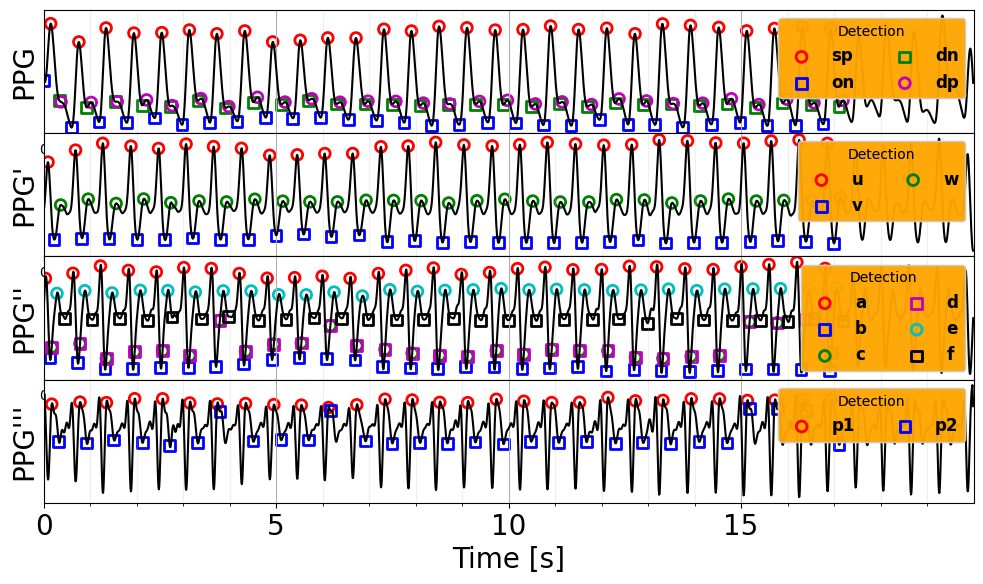

Figure has been saved in the "temp_dir".


In [ ]:
# Create a fiducials class
fp = Fiducials(fiducials)

# Plot fiducial points
plot_fiducials(s, fp, savingfolder, legend_fontsize=12)

Calculate PPG SQI:
_________________________

In [ ]:
# Get PPG SQI
ppgSQI = round(np.mean(SQI.get_ppgSQI(s.ppg, s.fs, fp.sp)) * 100, 2)
print('Mean PPG SQI: ', ppgSQI, '%')

Mean PPG SQI:  99.26 %


Calculate PPG biomarkers:
_________________________

Initialise the biomarkers package

In [ ]:
bmex = BM.BmCollection(s, fp)

Extract biomarkers

In [ ]:
bm_defs, bm_vals, bm_stats = bmex.get_biomarkers()
tmp_keys=bm_stats.keys()
print('Statistics of the biomarkers:')
for i in tmp_keys: print(i,'\n',bm_stats[i])

# Create a biomarkers class
bm = Biomarkers(bm_defs, bm_vals, bm_stats)

Statistics of the biomarkers:
ppg_sig 
                     Tpi       Tpp      Tsys      Tdia       Tsp       Tdp  \
Statistics                                                                  
mean           0.598571  0.599143  0.345714  0.183714  0.159143  0.414857   
median         0.600000  0.600000  0.344000  0.180000  0.160000  0.416000   
std            0.010913  0.006534  0.010110  0.013435  0.005792  0.016660   
percentile_25  0.592000  0.592000  0.336000  0.176000  0.158000  0.406000   
percentile_75  0.608000  0.602000  0.354000  0.192000  0.160000  0.424000   
iqr            0.016000  0.010000  0.018000  0.016000  0.002000  0.018000   
skew           0.155789 -0.194138  0.123521  1.051691 -0.399652 -0.426608   
kurtosis      -0.742472 -0.717518 -1.100450  0.890221  0.140338 -0.498165   
mad            0.008959  0.005163  0.008490  0.010571  0.004143  0.013878   

                 deltaT     Tsw10         Tsw25         Tsw33  ...  \
Statistics                                

Save PPG data:
______________

In [ ]:
# Save PPG struct, fiducial points, biomarkers
fp_new = Fiducials(fp.get_fp() + s.start_sig) # here the starting sample is added so that the results are relative to the start of the original signal (rather than the start of the analysed segment)
save_data(s, fp_new, bm, savingformat, savingfolder)

Results have been saved into the "temp_dir".
